# Práctica 2: Aprendizaje y selección de modelos de clasificación

### Minería de Datos: Curso académico 2020-2021

* Ángel Torres del Álamo
* José Ángel Royo López

# Introducción

Como ocurría con la práctica 1 de análisis exploratorio, vamos a crear un *notebook* replicando la libreta y utilizando el script proporcionado por `Júan Carlos Alfaro Jiménez`, al que al igual que en la práctica anterior le hemos agregado la función que nos permite eliminar outlier (`outlier_rejection`).

En este caso los dataset de `Diabetes` y `Winconsin` crearemos modelos simples y *ensembles* de estos modelos, conociendo y estudiando sus hiperparámetros para luego optimizarlos y sacar el mejor resultado de `tasa de acierto` posible para cada modelo.

Como tercer punto de esta práctica hemos replicado una libreta de kaggle, corrigiendo algunos de sus errores, que para adelantar podemos decir que comete fuga de datos.

Primero como es habitual, cargaremos las librerias que hemos utilizado.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

# Third party
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import clone
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer
from imblearn.pipeline import make_pipeline
from imblearn import FunctionSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

# Local application
import miner_a_de_datos_aprendizaje_modelos_utilidad as utils

# Dataset Diabetes

Establecemos una semilla para que los resultados sean reproducibles.

In [ ]:
random_state = 27912

## Carga de datos.

Como es habitual, cargamos los datos del dataset de `Diabetes`.

In [ ]:
filepath = "../input/pima-indians-diabetes-database/diabetes.csv"

index_col = None
target = "Outcome"

data = utils.load_data(filepath, index_col, target)

In [ ]:
data.sample(5,random_state=random_state)

Dividimos la base de datos.

In [ ]:
(X, y) = utils.divide_dataset(data, target)

Comprobamos que se ha dividido correctamente.

In [ ]:
X.sample(5,random_state=random_state)

In [ ]:
y.sample(5,random_state=random_state)

Dividimos el conjunto de entrenamiento y de test con un *houdout* estratificado, de igual manera que lo hicimos en la práctica 1.

In [ ]:
stratify = y
train_size = 0.7

(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                                      stratify=stratify,
                                                      train_size=train_size,
                                                      random_state=random_state)

Comprobamos las particiones.

In [ ]:
X_train.sample(5, random_state=random_state)

In [ ]:
X_test.sample(5,random_state=random_state)

## Creación del pipeline.

Utilizaremos el pipeline discretizado que creamos y analizamos en el estudio de la práctica anterior. Con las funciones y decisiones ya vistas en la anterior práctica.

Estas son las columnas que eliminaremos.

In [ ]:
delete_colum = ['SkinThickness','Insulin']

Estas son las columnas que utilizará el imputador para establecer un valor válido a los valores perdidos.

In [ ]:
imputer_col = ['Glucose','BloodPressure','BMI','DiabetesPedigreeFunction','Age']

El imputador funcionará mediante los k-vecinos como ya vimos en el primer estudio. Con la diferencia de que en este estudio se búscara el número de vecinos y el peso de los vecinos óptimo para el modelo que estamos estudiando.

In [ ]:
knnimputer = KNNImputer(n_neighbors=5, weights="uniform",missing_values=0)

La eliminación de las columnas y el imputador estarán dentro de un `Column Transformer`, ya que solo queremos que estas acciones las hagan las columnas que hemos visto anteriormente.

In [ ]:
column_transformer = make_column_transformer(("drop", delete_colum),(knnimputer, imputer_col), remainder="passthrough")

Y por último definimos el discretizador, donde el hiperparámetro de `n_bins` tambien sera optimizado.

In [ ]:
discretizer = KBinsDiscretizer(n_bins=2, strategy="uniform", encode="onehot-dense")

## Validación cruzada.

Para empezar vamos a definir la validación cruzada que vamos a utilizar para entrenar los modelos. Utilizamos una validación cruzada estratificada de $5x10-cv$, que como vimos en clase de prácticas es la más idonea para este tipo de validación cruzada.

In [ ]:
n_splits = 10
n_repeats = 5

cv = RepeatedStratifiedKFold(n_splits=n_splits,
                             n_repeats=n_repeats,
                             random_state=random_state)

## Modelos de clasificación supervisada

Para la simplificación a la hora de escribir y como el dataset completo lo tenemos ya guardado. Vamos a cambiar el nombre de `X_train` e `y_train` a `X` e `Y` respectivamente.

In [ ]:
X = X_train
y = y_train

Y tambíen, antes de empezar vamos a establecer el conjunto de los valores de los hiperparámetros de nuestro pipeline que utilizaremos para encontrar el más óptimo en todos los diferentes modelos (excepto los hiperparámetros de los estimadores).

In [ ]:
# ****Los comentarios en codigo no tendran tildes o caracteres especiales para ahorrarnos errores. *****

n_bins_discretizer = [1, 2, 3]           # Numero de particiones
n_imputer = [5, 10]                      # Numero de vecinos
knn_weights = ["uniform", "distance"]    # Peso de los vecinos

* `n-bins`: Hemos escogido este conjunto para el discretizador porque en el primer estudio, de forma gráfica, vimos que el número de particiones no iba a ser muy elevado, como mucho veiamos 2 particiones claras.
* `n_neighbors`: En el conjunto para los vecinos del imputador hemos cogido número impares porque reduce los casos de empate y no hemos puesto un número elevado de opciones para que el algortimo no tarde mucho en ejecutarse, ya que tiene un alto coste computacional.
* `weights`: Por último, en el peso de los vecinos, son todas las opciones que existen para ese hiperparámetro.

### K-Vecinos

El primer modelo a estudiar es de los `K-Vecinos`, mediante la clase `KNeighborsClassifier` de sklearn. Los hiperparámetros más importantes de este modelo y los que analizaremos son:
* `n_neighbors` (Número de vecinos)
* `weights` (Pesos de los vecinos)

In [ ]:
n_neighbors = 10 # Por defecto, el optimizador encontrara el numero de vecinos que de más score.

k_neighbors_model = KNeighborsClassifier(n_neighbors)

Creamos el pipeline con lo visto anteriormente y el estimador. Lo creamos de una forma diferente al primer estudio, con `Pipeline` en lugar de `make_pipeline` para poder ponerle los nombres en lugar de que te los genere automaticamente. Obtenemos el nombre de los parámetros para saber cuales son y como escribirlos a la hora de optimizarlos.

In [ ]:
estimator = k_neighbors_model
pip = Pipeline([('ct',column_transformer),('discretizer',discretizer),('estimator',estimator)])
pip.get_params().keys()

Utilizaremos para los hiperparámetros:
* `weights`: Todos los posibles valores de weights (uniform, distance)
* `n_neighbors`: Los valores pequeños los eliminaremos ya que el modelo se sobreajusta, valores altos llevarán al modelo a parecerse a un 0-R y los valores pares de menor valor los eliminaremos porque producen empate. 

In [ ]:
weights = ["uniform", "distance"]
n_neighbors = [5, 6, 7, 8, 9]

k_neighbors_clf = utils.optimize_params(pip,
                                        X, y, cv,
                                        estimator__weights=weights,
                                        estimator__n_neighbors=n_neighbors,
                                        ct__knnimputer__n_neighbors = n_imputer,
                                        ct__knnimputer__weights = knn_weights,
                                        discretizer__n_bins = n_bins_discretizer
                                        )

Para estudiar el resultado que nos ha dado el algortimo de optimización vamos a ir por partes. Primero analizaremos los hiperparámetros del imputador, luego los del discretizador y por último los del estimador.

Para KNN el imputador ha sacado un resultado de `10 vecinos` y un peso `uniforme`. Estos resultados son los mejores que el algortimo al imputar los valores perdidos dan más información al clasificador para mejorar el score.

Para el discretizador ha resultado en `3 particiones`. Lo cual es diferente a como lo vimos en el análisis exploratorio, según las gráficas el resultado más claro que teniamos es de 2 particiones. Pero, al ojo humano hay cosas que se escapan y más con una base de datos grande, que una máquina "ve" de mejor forma.

Para el estimador KNN ha sacado un resultado de `5 vecinos` y un peso `uniforme`. Es un número de vecinos intermedio que permite que las fronteras de decisión queden más definidas. Al tener todos los vecinos el mismo peso, la información que debe guardar es mejor. Son unos buenos hiperparámetros que sin este algortimo de decisión podiamos haber utilizado por criterio.

Tasa de acierto resultante: $0.755 \pm 0.05$

### Árboles de decisión.

El siguiente modelo a analizar es el de `árboles de decisión`, mediante la clase `DecisionTreeClassifier` de sklearn. Los hiperparámetros más importantes son:
* `criterion` (criterio de corte)
* `max_depth` (profundidad máxima del árbol)
* `cpp_alpha` (coste de complejidad para encontrar el subárbol óptimo, este parámetro decidirá si hacer la poda)

In [ ]:
decision_tree_model = DecisionTreeClassifier(random_state=random_state)

Como haremos en todos los diferentes modelos, creamos el pipeline y generamos el diccionario para conocer los diferentes hiperparámetros de el pipeline creado. Por tanto, no volveremos a comentar este paso.

In [ ]:
estimator = clone(decision_tree_model)
pip = Pipeline([('ct',column_transformer),('discretizer',discretizer),('estimator',estimator)])
pip.get_params().keys()

Utilizaremos para los hiperparámetros:
* `criterion`: Todos los posibles valores de criterion (gini, entropy)
* `max_depth`: Hasta un valor de profundidad 4, como hemos dicho en el primer estudio no hemos encontrado muchos cortes para separar la variable clase, por tanto, el árbol no se ramificará tanto y ramificarse tanto supone que el modelo se sobreajuste.
* `ccp_alpha`: Los valores de alpha son muy pequeños y un buen árbol intentará tener el más bajo.

In [ ]:
criterion = ["gini", "entropy"]
max_depth = [0, 1, 2, 3, 4]
ccp_alpha = [0.0, 0.1, 0.2]

decision_tree_clf = utils.optimize_params(pip,
                                          X, y, cv,
                                          estimator__criterion=criterion,
                                          estimator__max_depth=max_depth,
                                          estimator__ccp_alpha=ccp_alpha,
                                          ct__knnimputer__n_neighbors = n_imputer,
                                          ct__knnimputer__weights = knn_weights,
                                          discretizer__n_bins = n_bins_discretizer
                                         )

Utilizaremos el mismo orden de evaluación que con el modelo anterior.

En la primera posición hay muchos empates, el resultado de la tabla nos muestra las 5 primeras filas y todas consiguen la misma puntación. El algortimo nos ha imprimido por pantalla los mejores hiperparámetros resultados, pero esta no es la única combinación posible, si no que es la primera que el algortimo ha entrenado.

Como vemos en el resultado y en las tablas hay muchas combinaciones de mejores resultados: 

* Teniendo para el imputador todo el conjunto de hiperparámetros. 
* Para el discretizador por 2 y 3 particiones.
* Para el estimador, todas las profundidades de árboles del conjunto que hemos indicado, los diferentes criterios de corte y un alpha de 0.0 y 0.1. Un resultado de alpha pequeño permite tener resultados de subárboles óptimos.

Estos resultados son los mejores que podemos utilizar para este modelo. Aunque los que ha devuelto el algoritmo son los que se utilizarán en la evaluación de todos los modelos.

Tasa de acierto resultante: $0.747 \pm 0.062$	

### AdaBoost.

El siguiente modelo a analizar es el de `adaboost` o `boosting`, mediante la clase `AdaBoostClassifier` de sklearn. Los hiperparámetros más importantes son:
* `base_estimator` (el estimador base del modelo que será un árbol de decision)
* `learning_rate` (tasa de aprendizaje, reduce la importancia de cada clasificador)

Hemos visto que como hiperparámetro, adaboost tiene un árbol de decisión por lo que los hiperparámetros de este modelo también estarán incluidos. Muchos de los *ensembles* que estabmos viendo funcionaran con árboles de decisión y por lo tanto con sus hiperparámetros.
* `criterion` (criterio)
* `max_depth` (profundidad máxima)
* `cpp_alpha` (coste de complejidad)

In [ ]:
adaboost_model = AdaBoostClassifier(random_state=random_state)

In [ ]:
estimator = adaboost_model

pip = Pipeline([('ct',column_transformer),('discretizer',discretizer),('estimator',estimator)])
pip.get_params().keys()

En este caso los hiperparámeetros del árbol de decisión serán menores que anteriormente para que el coste computacional baje y viendo los resultados de la optimización anterior nos parece lo correcto.
* `ccp_alpha`: Solo dos conjuntos de alpha, los que hemos visto anteriormente que eran mejor para el árbol de decisión.
* `criterion`: Todos los criterios posibles ya que no son muchos (gini y entropy).
* `max_depth`: Como nos indica en la libreta de "Aprendizaje de Modelos", el algortimo de adaboost funciona mejor con árboles de decisión poco profundos (*shallow decision trees*), por su poder de generalización. Por esto, el conjunto de profundidad va a ser de números bajos (1 y 2).

Para el resto de hiperparámetros:
* `base_estimator`: Con los hiperparámetro anteriores se encontrará el mejor estimador base, siendo este un árbol de decisión.
* `learning_rate`: Por defecto este hiperparámetro es de 1. Entonces necesitaremos números cercanos a este. Probaremos con 1 y 0.95.

In [ ]:
# Should not modify the base original model
base_estimator = clone(decision_tree_model)

base_estimator = [base_estimator]
learning_rate = [0.95, 1.0]
criterion = ["gini", "entropy"]
max_depth = [1, 2]
ccp_alpha = [0.0, 0.1]

adaboost_clf = utils.optimize_params(pip,
                                     X, y, cv,
                                     estimator__base_estimator=base_estimator,
                                     estimator__learning_rate=learning_rate,
                                     estimator__base_estimator__criterion=criterion,
                                     estimator__base_estimator__max_depth=max_depth,
                                     estimator__base_estimator__ccp_alpha=ccp_alpha,
                                     ct__knnimputer__n_neighbors = n_imputer,
                                     ct__knnimputer__weights = knn_weights,
                                     discretizer__n_bins = n_bins_discretizer
                                     )

Siguiendo el orden que hemos establecido:

Para el imputador KNN el número de vecinos es de `5` y un peso `uniform`. Los valores por defecto que hemos elegido y hemos visto que funcionan bien.

Para el discretizador el número de particiones es de `3 particiones`. Como hemos comentado en k-vecinos, este resultado no lo esperabamos pero funciona mejor que discretizar en 2 particiones.

Para el estimador el número de profundidad máxima es de `1`. Vemos que con la mínima profunidad que hemos elegido obtiene el mejor resultado. El alpha de `0.0`, como ocurría en árboles de decisión. Para los dos últimos hiperparámetros, alpha y learning rate, vemos que cualquier combinación con el resto de hiperparámetros anteriores se obtiene el máximo *score*. Hay 4 empates en la primera posición, pero como ocurría anteriormente, se elegirá el que devuelve el algortimo que es el primero en crear.

Tasa de acierto resultante: $0.753 \pm 0.045$	

### Bagging.

El siguiente modelo a analizar es el de `bagging`, mediante la clase `BaggingClssifier` de sklearn. Los hiperparámetros más importantes son:
* `base_estimator` (el estimador base del modelo que será un árbol de decision)
* `criterion` (criterio de corte del árbol)

In [ ]:
bagging_model = BaggingClassifier(random_state=random_state)

In [ ]:
estimator = bagging_model
pip = Pipeline([('ct',column_transformer),('discretizer',discretizer),('estimator',estimator)])
pip.get_params().keys()

Para los hiperparámetros de bagging escogeremos:
* `base_estimator`: El árbol de decisión creado anteriormente.
* `criterion`: Todas las combinaciones de criterio para el árbol (gini, entropy)

También vamos a incluir la profundidad máxima del árbol, ya que bagging funciona mejor con árboles de decisión profundos.
* `max_depth`: Vamos a probar con la profundidad por defecto que es 1, 4 y 10 (muy profundo).

In [ ]:
# Should not modify the base original model
base_estimator = clone(decision_tree_model)

base_estimator = [base_estimator]
criterion = ["gini", "entropy"]
max_depth = [1,4,10]

bagging_clf = utils.optimize_params(pip,
                                    X, y, cv,
                                    estimator__base_estimator=base_estimator,
                                    estimator__base_estimator__criterion=criterion,
                                    estimator__base_estimator__max_depth=max_depth,
                                    ct__knnimputer__n_neighbors = n_imputer,
                                    ct__knnimputer__weights = knn_weights,
                                    discretizer__n_bins = n_bins_discretizer
                                    )

Como ocurre en el resto, hay muchos empates.Entonces, para el imputador KNN el número de vecinos y el peso produce un mismo resultado final.

Para el discretizador el número de particiones es de `2 particiones`. Para este clasificador, vemos en los resultados que este valor de partición es el más idoneo.

Por los empates que encontramos, para el estimador el criterio del árbol de decision da igual si es por entropía o gini. Mientra que la profundidad máxima del árbol encontrada es de `1 de profundidad`. Con el valor por defecto encuentra el mejor *score*

Tasa de acierto resultante: $0.747 \pm 0.062$

### Random Forest.

El siguiente modelo a analizar es el de `random forest`, mediante la clase `RandomForestClassifier` de sklearn. Los hiperparámetros más importantes son:
* `criterion` (criterio de partición)
* `max_features` (número de atributos para buscar la mejor partición)

In [ ]:
random_forest_model = RandomForestClassifier(random_state=random_state)

In [ ]:
estimator = random_forest_model
pip = Pipeline([('ct',column_transformer),('discretizer',discretizer),('estimator',estimator)])

Para los hiperparámetros de random forest:
* `criterion`: Los dos diferentes valores que hemos visto en el resto de ejemplos.
* `max_features`: Para este hiperparámetro utilizaremos sqrt y log2 aunque tambíen existe la posibilidad de auto (visto en la documentación de sklearn), funciona de la misma forma que sqrt. Como su nombre indica, sqrt hace la raiz cuadrada del número de atributos y log2 hace el logaritmo en base 2 del número de atributos.

In [ ]:
criterion = ["gini", "entropy"]
max_features = ["sqrt", "log2"]

random_forest_clf = utils.optimize_params(pip,
                                          X, y, cv,
                                          estimator__criterion=criterion,
                                          estimator__max_features=max_features,
                                          ct__knnimputer__n_neighbors = n_imputer,
                                          ct__knnimputer__weights = knn_weights,
                                          discretizer__n_bins = n_bins_discretizer
                                          )

Tenemos dos empates en la primera posición, vamos a indicar que valores son los mejores y cuales dan igual.

Para el imputador KNN el número de vecinos es de `10` y un peso `uniform`. Al igual que ocurria con el modelo de clasificación de K-Vecinos.

Para el discretizador el número de particiones es de `3 particiones`.

Para el estimador el criterio elegido es por `entropía` y con el máximo de características da igual si son por raiz cuadrada o logartimo en base 2.

Tasa de acierto resultante: $0.746 \pm 0.052$

### Gradient Boosting.

El siguiente modelo a analizar es el de `gradient boosting`, mediante la clase `GradientBoostingClassifier` de sklearn. Los hiperparámetros más importantes son:
* `learning rate` (tasa de aprendizaje)
* `criterion` (criterio de partición)
* `max_depth` (máxima profundidad)
* `cpp_alpha` (coste de complejidad)

In [ ]:
gradient_boosting_model = GradientBoostingClassifier(random_state=random_state)

In [ ]:
estimator = gradient_boosting_model
pip = Pipeline([('ct',column_transformer),('discretizer',discretizer),('estimator',estimator)])

Para los hiperparámetros de gradient boosting:

* `learning rate`: Por defecto la tasa de aprendizaje es de 0.01. Entonces, utilizaremos valores cercanos a este.
* `criterion`: Para este modelo el clasificador es diferente a los árboles de decisión ya que se usan los residuos de las modelos aprendidos. Tenemos entonces mse o error cuadrático medio (ECM) y Friedman mse o el ECM de Friedman.
* `max_depth`: Máxima profundidad del árbol que aprende, cogeremos valores pequeños que hemos visto que funcionan bien.
* `cpp_alpha`: Y el coste de complejidad como siempre.

In [ ]:
learning_rate = [0.01, 0.05, 0.1]
criterion = ["friedman_mse", "mse"]
max_depth = [1, 2]
ccp_alpha = [0.0, 0.1]

gradient_boosting_clf = utils.optimize_params(pip,
                                              X, y, cv,
                                              estimator__learning_rate=learning_rate,
                                              estimator__criterion=criterion,
                                              estimator__max_depth=max_depth,
                                              estimator__ccp_alpha=ccp_alpha,
                                              ct__knnimputer__n_neighbors = n_imputer,
                                              ct__knnimputer__weights = knn_weights,
                                              discretizer__n_bins = n_bins_discretizer
                                              )

Como es habitual tenemos empates en el primer puesto. Diremos que valores de loshiperparámetros son los mejores y cuales dan igual entre unos y otros.

Para el imputador KNN el número de vecinos es de `5` y un peso `distance`

Para el discretizador el número de particiones es de `3 particiones`

Para el estimador el alpha elegido es `0.0` (para el árbol de decisión hemos visto que es el mejor alpha en el problema), la tasa de aprendizaje es la intermedia entre los diferentes valores elegidos `0.05`, la máxima profundidad es de `1`. Por último, para el criterio da igual entre el ECM y el ECM de friedman, el empate ocurre en esta dos combinaciones de los valores ya vistos y los posibles del criterio.

Tasa de acierto resultante: $0.752 \pm 0.046$	

### Histogram Gradient Boosting.

El siguiente modelo a analizar es el de `histogram gradient boosting`, mediante la clase `HistgradientBoostingClassifier` de sklearn. Los hiperparámetros más importantes son:
* `learning rate` (tasa de aprendizaje)
* `max_leaf_nodes` (máximo número de nodos hoja)

In [ ]:
hist_gradient_boosting_model = HistGradientBoostingClassifier(random_state=random_state)

In [ ]:
estimator = hist_gradient_boosting_model
pip = Pipeline([('ct',column_transformer),('discretizer',discretizer),('estimator',estimator)])

Por último, los hiperparámetros para historical gradient boosting son:
* `learning rate`: Igual que con gradient boosting, el valor por defecto es 0.1. Tendremos valores cercanos a este.
* `max_leaf_nodes`: Y por último, el número máximo nodos hoja. Tendremos valores diferentes entre ellos para ver cual mejora el modelo, pondremos valores bajos porque hemos visto que nuestro árbol no crea mucha profundidad y no especifica tanto.

In [ ]:
learning_rate = [0.01, 0.05, 0.1]
max_leaf_nodes = [5,10,15, 31]

hist_gradient_boosting_clf = utils.optimize_params(pip,
                                                   X, y, cv,
                                                   estimator__learning_rate=learning_rate,
                                                   estimator__max_leaf_nodes=max_leaf_nodes,
                                                   ct__knnimputer__n_neighbors = n_imputer,
                                                   ct__knnimputer__weights = knn_weights,
                                                   discretizer__n_bins = n_bins_discretizer
                                                   )

Para el imputador KNN el número de vecinos es de `10` y un peso `uniform`.

Para el discretizador el número de particiones es de `3 particiones`.

Para el estimador la tasa de aprendizaje es `0.1` la mayor del conjunto y por defecto y el máximo número de nodos hoja es 15 o 31, hay un empate.

Tasa de acierto resultante: $0.751 \pm 0.046$

## Construcción y validación del modelo final

Por último, vamos a ver de todos los modelos que hemos visto y creado cual es el que obtiene una tasa de acierto mayor para el conjunto de entrenamiento que hemos dividido con el *houldout*.

En el proceso de optimización con validación cruzada el mejor resultado de tasa de acierto lo obteniamos con K-Vecinos con `0.755` seguido muy cerca de AdaBoost (`0.753`) y Grandient Boosting (`0.752`). Todo esto dentro del conjunto de entrenamiento.

In [ ]:
estimators = {
    "Nearest neighbors": k_neighbors_clf,
    "Decision tree": decision_tree_clf,
    "AdaBoost": adaboost_clf,
    "Bagging": bagging_clf,
    "Random Forests": random_forest_clf,
    "Gradient Boosting": gradient_boosting_clf,
    "Histogram Gradient Boosting": hist_gradient_boosting_clf
}

Mediante la lista de estimadores que hemos creado y una función en el script vamos a evaular todos los modelos.

In [ ]:
X = X_test
y = y_test

utils.evaluate_estimators(estimators, X, y)

Gradient Boosting es el modelo que obtiene la mejor tasa de acierto con un `0.757576` de todos los estudiados. La mayoría de ensembles nos dan una tasa de acierto mayor que modelos simples como árboles de decisión. Cabe remarcar que KNN da una tasa de acierto considerable para el tipo de modelo que es. Por ello, vamos a hacer una evaluación en terminos de coste para elegir el mejor clasificador para este dataset.

Los modelos *ensemble* son modelos computacionalmente más costos, por tanto el tiempo de inferencia es mucho mayor que modelos como Árboles de Decisión o KNN. A la hora de elegir que modelo es mejor no solo nos podemos fijar en terminos de tasa de aciertos (*score*), si un modelo *ensemble* y un modelo sencillo consiguen resultados muy parecidos o iguales es mejor elegir el modelo sencillo.

En los resultados observanos que KNN obtiene la misma tasa de acierto que Random Forest (`0.727273`). En este caso eligiriamos hacer nuestro clasificador con KNN por la sencillez de este. También, Decision Tree y Bagging obtienen un mismo *score* (`0.718615`), ocurriría lo mismo que anteriormente.

Entonces, vemos que modelos como KNN consiguen más puntuación que muchos de los *ensembles* e incluso estos modelos que quedan por encima de KNN tienen una diferencia poco significativa que haría que nos decatasemos por el modelo de los vecinos cercanos.

# Dataset Wisconsin

## Carga de datos

Vamos a empezar cargando las datos al igual que hicimos en la práctica anterior.

In [ ]:
filepath = "../input/wisconsin/wisconsin.csv"

index_col = "id"
target = "diagnosis"

data = utils.load_data(filepath, index_col, target)

Y comprobando que se han cargado correctamente:

In [ ]:
data.sample(5, random_state=random_state)

A su vez, lo dividimos en variables predictoras (X) y variable clase (y):

In [ ]:
(X, y) = utils.divide_dataset(data, target)

Vamos a comprobar que se ha separado correctamente. Comenzamos con las variables predictoras:

In [ ]:
X.sample(5, random_state=random_state)

Y continuamos con la variable clase:

In [ ]:
y.sample(5, random_state=random_state)

Por último, dividimos el conjunto de datos en entrenamiento y prueba mediante un holdout estratificado:

In [ ]:
stratify = y
train_size = 0.7

(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                                      stratify=stratify,
                                                      train_size=train_size,
                                                      random_state=random_state)

Y nos aseguramos que se ha realizado adecuadamente. Comenzamos con el conjunto de datos de entrenamiento:

In [ ]:
X_train.sample(5, random_state=random_state)

In [ ]:
y_train.sample(5, random_state=random_state)

Y finalizamos con el conjunto de datos de prueba:

In [ ]:
X_test.sample(5, random_state=random_state)

In [ ]:
y_test.sample(5, random_state=random_state)

## Pipeline

Dado que en la práctica anterior se realizó un análisis exploratorio de los datos para sacar unas conclusiones que nos ayudaran a hacer un buen preprocesamiento de datos, vamos a aprovechar que ya disponemos de esta información y a aplicar el pipeline que calculamos en la práctica anterior.

En la práctica anterior habíamos definido una función para eliminar estas columnas y las eliminábamos mediante un FuctionTransformer, pero ahora las vamos a eliminar con la función make_column_transformer ya que así no necesitamos crear nosotros nuestra propia función.

Ahora vamos a crear un column transformer que nos permita eliminar las variables que habíamos detectado que eran inútiles y la variable corrupta `Unnamed: 32`.

In [ ]:
column_rm_mean = ["smoothness_mean", "symmetry_mean", "fractal_dimension_mean"]
column_rm_se = ["texture_se", "smoothness_se", "symmetry_se", "fractal_dimension_se"]
column_rm_worst = ["symmetry_worst", "fractal_dimension_worst"]
column_error = ["Unnamed: 32"]
column_rm = column_rm_mean + column_rm_se + column_rm_worst + column_error

drop_col = make_column_transformer(("drop", column_rm), remainder="passthrough")

Ahora definimos un FuctionSampler que nos permite eliminar los outlier.

In [ ]:
outlier_rm = FunctionSampler(func=utils.outlier_rejection, kw_args={'seed':random_state})

Como último elemento del Pipeline creamos el discretizador que le vamos a pasar. En la práctica anterior mediante el análisis multivariado observamos que lo mejor era discretizar las variables en dos intervalos, pero como ahora vamos a realizar una validación cruzada para elegir los mejores hiperparámetros de cada algoritmo para este dataset, también vamos a incluir que compruebe a discretizar en 3 intervalos, para comprobar que si las conclusiones del análisis multivariado eran correctas.

In [ ]:
discretizer = KBinsDiscretizer(n_bins=2, strategy="uniform", encode="onehot-dense")

Indicar que todavía no podemos crear el pipeline, pues hay que crear un pipeline para cada modelo, ya que hay que incluir dicho modelo en el pipeline.

## Selección de modelos de clasificación supervisada

Antes de empezar con los modelos tenemos que definir la validación cruzada que les vamos a aplicar. En concreto vamos a definir una 5x10 validación cruzada estratificada al igual que para `Diabetes`.

In [ ]:
n_splits = 10
n_repeats = 5

cv = RepeatedStratifiedKFold(n_splits=n_splits,
                             n_repeats=n_repeats,
                             random_state=random_state)

Para simplificar vamos a renombrar a las variables de entrenamiento.

In [ ]:
X = X_train
y = y_train

Vamos a definir que valores para el discretizador vamos a optimizar mediante la validación cruzada. En este caso como se dijo anteriormente vamos a probar si efectivamente es mejor el discretizador con dos intervalos que con tres (se validará para todos los modelos).

In [ ]:
n_bins = [2, 3]

### Vecinos más cercanos

Vamos a empezar la selección de modelos con el algoritmo de los vecinos más cercanos.

Para ello igual que con el dataset Diabetes vamos a utilizar la clase KNeighborsClassifier. Así que vamos a crearlo y lo vamos a añadir en el pipeline junto con los otros elementos que definimos en el apartado del pipeline.

Después vamos a usar el método get_params().key() que nos devuelve una lista con el nombre de todos los hiperparámetros que hay en el pipeline. Esto es importante porque para indicar los hiperparámetros a optimizar necesitamos conocer su nombre, y al incluir el modelo k vecinos en el pipeline los nombres de sus hiperparámetros cambian.

In [ ]:
k_neighbors_model = KNeighborsClassifier()

pipe_k_neighbors = make_pipeline(drop_col, outlier_rm, discretizer, k_neighbors_model)
pipe_k_neighbors.get_params().keys()

Por ejemplo el hiperparámetro n_neighbors ahora se llama kneighborsclassifier__n_neighbors. Y el hiperparámetro n_bins del discretizador se llama kbinsdiscretizer__n_bins.

Podemos llegar a la conclusión que la forma de llamar a los hiperparámetros del pipeline es el nombre de la clase en minúsculas (kneighborsclassifier, kbinsdiscretizer), seguido de dos barras bajas (__) y seguido del nombre del hiperparámetro original.

Los hiperparámetros que vamos a optimizar en este caso son:

* n_neighbors. El número de vecinos. Vamos a probar entre 1 y 6 vecinos.
* weights. La función de peso que utilizará el algoritmo de los vecinos más cercanos. Probaremos con las funciones de peso uniform y distance.
* Además, como se indicó anteriormente que siempre vamos a optimizar el número de intervalos del discretizador (2 o 3).

In [ ]:
weights = ["uniform", "distance"]
n_neighbors = [1, 2, 3, 4, 5, 6]

k_neighbors_clf = utils.optimize_params(pipe_k_neighbors,
                                        X, y, cv,
                                        kneighborsclassifier__weights=weights,
                                        kneighborsclassifier__n_neighbors=n_neighbors,
                                        kbinsdiscretizer__n_bins=n_bins)

Hemos obtenido que la configuración de hiperparámetros óptima para este caso en concreto es utlizar 4 vecinos, la función de peso distancia y discretizar las variables predictoras en tres intervalos.

Como nos podíamos imaginar hemos obtenido un número de vecinos intermedio, en este caso 4. Esto es debido a que si generamos un modelo utilizando solo al vecino más cercano, estaríamos creando un modelo muy sobreajustado a los datos de entrenamiento que no sería capaz de generalizar, ya que solo se fija en el dato más cercano. Si por el contrario generamos un modelo que utiliza una gran cantidad de vecinos para clasificar, se generaría un modelo similar al 0R ya que clasificaría como la clase mayoritaría.

Podemos ver que los valores elegidos para n_neighbors en las mejores configuraciones de parámetros tienen un valor de entre 3 y 6. Pudiendo ver que utilizar solo 1 o 2 vecinos han obtenido peores resultados porque como hemos indicado se ajustan a los datos y no permiten que el modelo sea capaz de generalizar.

Como vemos hemos obtenido como función de peso distance en la configuración óptima, incluso parece que funciona bien con este dataset pues si miramos las cinco mejores configuraciones obtenidas se ha elegido distance en cuatro de ellas. Esto es porque esta función le asigna un peso en función de la distancia que hay entre el punto a clasificar y los puntos más cercanos, mientras que uniform le aigna el mismo peso, independientemente de la distancia que haya. Aún así, dependiendo del dataset que estemos tratando y de otros factores (como el preprocesamiento que se haya realizado y como afecten el resto de hiperparámetros) puede ser que funcione mejor otra función de pesos.

Por último, tenemos que indicar que por el contrario a lo que nos esperábamos, en este caso ha funcionado mejor un discretizado con tres intervalos que con dos, tal y como vimos que debería de funcionar mejor en el análisis exploratorio de la práctica anterior.

Comprobaremos con el resto de modelos si se trata de un caso aislado y es que para este modelo en concreto funciona mejor con 3 intervalos, o es que nuestra conclusión del análisis exploratorio estaba equivocada.

### Árboles de decisión

Para los árboles de decisión vamos a usar la clase DecisionTreeClassifier y la vamos a agregar al pipeline de la misma forma hicimos con los k vecinos. También observaremos el nombre de los hiperparámetros, aunque por las conclusiones que sacamos en el k vecinos nos podemos imaginar como serán.

In [ ]:
decision_tree_model = DecisionTreeClassifier(random_state=random_state)

pipe_tree = make_pipeline(drop_col, outlier_rm, discretizer, decision_tree_model)
pipe_tree.get_params().keys()

Los árboles de decisión tienen más hiperparámetros que el modelo de los k vecinos, aunque no podemos optimizarlos todos ya que implicaría un gran coste computacional, necesitando mucho tiempo.

Por eso seleccionaremos los que creamos más importantes. Optimizaremos:

* criterion. El criterio utilizado para seleccionar la mejor partición, que puede ser gini o entropía.
* max_depth. La máxima profundidad del árbol, que probaremos con 3, 4 y 5. No probando con 1 y 2 porque el árbol saldría muy pequeño y obtendríamos un modelo con underfitting. Por el contrario si obtenemos un árbol muy grande (con profundidad mayor que 6) tendríamos un modelo con overfitting, es decir sería demasiado complejo y se ajustaría demasiado a los datos de entrenamiento.
* ccp_alpha. Parámetro de complejidad que usa el algoritmo de post-poda, es decir, este hiperparámetro nos permitirá decidir si podar alguna rama del árbol. 

Otro hiperparámetro que podría resultar interesante sería el min_samples_split o el min_samples_leaf que representan al mínimo número de registros que tiene que haber en un nodo para poder ramificarlo, y el mínimo número de ejemplos que tiene que haber en un nodo para que pueda ser hoja. Esto nos ayudaría a reducir el sobreajuste, aunque como esto ya lo hacemos con el max_depth no vamos a optimizar estos hiperparámetros pues sería muy costoso.

In [ ]:
# Should not modify the original model
estimator = clone(decision_tree_model)

criterion = ["gini", "entropy"]
max_depth = [3, 4, 5]
ccp_alpha = [0.0, 0.1]

decision_tree_clf = utils.optimize_params(pipe_tree,
                                          X, y, cv,
                                          decisiontreeclassifier__criterion=criterion,
                                          decisiontreeclassifier__max_depth=max_depth,
                                          decisiontreeclassifier__ccp_alpha=ccp_alpha,
                                          kbinsdiscretizer__n_bins=n_bins)

Hemos obtenido como configuración óptima una profundidad máxima de 3, con un criterio gini, un 0.0 en el parámetro de post poda y ha discretizado en 2 intervalos.

Primero podemos ver que en este caso ha funcionado mucho mejor el discretizado en 2 intervalos como vimos en la práctica anterior, obteniendo mejores resultados en los que se ha usado 2 intervalos en lugar de 3, al contrario que en el k vecinos, en el que las 5 configuraciones óptimas utilizaban 3 intervalos para discretizar. Seguiremos observando en el resto de modelos para ver si obtienen 2 intervalos como en este caso.

Podemos ver también que la configuración óptima ha utilizado gini aunque si continuamos mirando en la tabla podemos ver que también se han obtenido buenos resultados con el criterio entropía. Así podemos concluir que el valor óptimo de este hiperparámetro varía en función de otros factores, como otros hiperparámetros o los datos que tengamos.

Como profundidad máxima hemos obtenido una profundidad de 3, generandose así un árbol que no es muy complejo. Esto es importante, ya que un árbol muy complejo implica que está sobreajustado a los datos de entrenamiento, además de generar reglas más complejas. Por eso podemos ver en la tabla que se han obtenido mejores resultados con árboles de profundidad 3 y 4 que los árboles de profundidad 5.

También vemos que se han obtenido mejores resultados con un valor de ccp_alpha de 0. Esto implica que no se poda en los árboles obtenidos. Este parámetro nos permite reducir la varianza en los árboles complejos, pero en este caso como no hemos generado árboles demasiado complejos pues parece que no ha obtenido buenos resultados podándolos. Ya que podemos ver que los mejores resultados se han obtenido con un valor de 0 para este hiperparámetro, mejor que con un valor de 0.1. Aún así es un hiperparámetro a tener en cuenta si se van a obtener árboles complejos en los que será necesario aplicar una postpoda.

### Adaptative Boosting (AdaBoost)

Vamos a empezar a validar los ensembles, para ello vamos a empezar con Boosting, en concreto con el algoritmo AdaBoost, utilizando la clase AdaBoostClassifier. Al igual que con los k vecinos y los árboles de decisión, lo vamos a incluir en el pipeline y ver el nombre de sus hiperparámetros.

In [ ]:
adaboost_model = AdaBoostClassifier(random_state=random_state)

pipe_adaboost = make_pipeline(drop_col, outlier_rm, discretizer, adaboost_model)
pipe_adaboost.get_params().keys()

Los hiperparámetros más importantes de AdaBoost son:

* n_estimator. Es el número de estimadores, que por defecto es 50. En este caso no lo vamos a validar ya que aumentaría bastante la complejidad computacional y tardaría mucho. Lo vamos a dejar en su valor por defecto. Como se nos indicó en clase, sabemos que en la teoría los ensembles funcionan mejor cuantos más estimadores utilicen, aunque en la práctica sabemos que esto no es siempre cierto, ya que depende de cada problema. Así que en este caso nos vamos a quedar con 50.
* base_estimator. Representa al estimador a utilizar por el AdaBoost. Utilizaremos un árbol de decisión y validaremos varios de sus hiperparámetros. Probaremos con una profundidad máxima de 1 y 2, con el criterio gini y entropía, y con un ccp_alpha de 0 y 0.1. Como se puede ver todos los árboles que vamos a probar son muy simples debido a que el AdaBoost funciona muy bien con modelos muy simples, reduciendo así su error debido al sesgo combinando estos modelos simples.
* learning_rate. Parámetro del ratio de aprendizaje que nos permite controlar cuanto contribuye cada estimador. Probaremos con 0.95 y 1.0.

In [ ]:
estimator = adaboost_model

# Should not modify the base original model
base_estimator = clone(decision_tree_model)

base_estimator = [base_estimator]
learning_rate = [0.95, 1.0]
criterion = ["gini", "entropy"]
max_depth = [1, 2]
ccp_alpha = [0.0, 0.1]

adaboost_clf = utils.optimize_params(pipe_adaboost,
                                     X, y, cv,
                                     adaboostclassifier__base_estimator=base_estimator,
                                     adaboostclassifier__learning_rate=learning_rate,
                                     adaboostclassifier__base_estimator__criterion=criterion,
                                     adaboostclassifier__base_estimator__max_depth=max_depth,
                                     adaboostclassifier__base_estimator__ccp_alpha=ccp_alpha,
                                     kbinsdiscretizer__n_bins=n_bins)

Hemos obtenido como hiperparámetros óptimos un learning rate de 1, utilizando 2 intervalos para discretizar en el preprocesamiento, y se ha utilizado como estimador un árbol de profundidad 1, con un criterio gini y un ccp_alpha de 0.

Podemos ver que ha funcionado mucho mejor el discretizado de dos intervalos en lugar de tres. Con lo que seguimos confirmando lo que vimos en el análisis exploratorio de la práctica anterior, que es que funciona mejor un discretizado en dos intervalos para este dataset.

También hemos obtenido un learning rate de 1, aunque también funciona bien el learning rate de 0.95, ya que en las 5 primeras combinaciones de hiperparámetros óptimos obtenidos podemos ver que en las dos primeras se ha obtenido un learning rate de 1, pero en las tres siguientes de 0.95.

Como árbol podemos ver que cuanto más simple era el árbol mejores resultados hemos obtenido, ya que los cuatro primeros árboles son de profundidad 1. Esto sigue lo que se indicó anteriormente y es que el algoritmo AdaBoost funciona mejor con estimadores muy simples (en este caso árboles de clasificación de 1 nivel) y al combinarlos permite reducir el error debido al sesgo. También vemos que se ha utilizado un ccp_alpha de 0, ya que teniendo árboles de un solo nivel no los puedes podar. Y como criterio ha dado mejores resultados gini, aunque al igual que vimos en los árboles de decisión, entropía también da buenos resultados, dependiendo más de su combinación con el valor de otros hiperparámetros.

### Bootstrap Aggregating (Bagging)

Después de validar AdaBoost, vamos a validar Bagging.

In [ ]:
bagging_model = BaggingClassifier(random_state=random_state)

pipe_bagging = make_pipeline(drop_col, outlier_rm, discretizer, bagging_model)
pipe_bagging.get_params().keys()

Bagging tiene más hiperparámetros que AdaBoost. No vamos a probarlos todos ya que tardaría mucho tiempo y hay que tener en cuenta que si sumamos el tiempo de cada modelo que estamos optimizando, tardaría demasiado, así que para reducir este tiempo solo vamos a optimizar:

* base_estimator. Este ensembler a diferencia de AdaBoost se beneficia de utilizar estimadores complejos, por lo que en lugar de optimizar el hiperparámetro base_estimator como hicimos en AdaBoost le vamos a pasar como valor para este hiperparámetro un árbol de decisión (de la clase DecissionTreeClassifier) con todos los hiperparámetros por defecto, para que así entrene los árboles más complejos posibles, dejándolos ramificar hasta el final. El único hiperparámetro que vamos a validar de los árboles es si utiliza como criterio gini o entropìa.
* n_estimators. Número de estimadores a aprender, que en AdaBoost no optimizamos ya que teníamos que optimizar algunas hiperparámetros del estimador base, pero en este caso como Bagging se aprovecha de estimadores complejos para reducir el error provocado por su varianza, en este caso vamos a probar con 10, 20 y 30 estimadores.

In [ ]:
estimator = bagging_model

# Should not modify the base original model
base_estimator = clone(decision_tree_model)

base_estimator = [base_estimator]
criterion = ["gini", "entropy"]
n_estimators = [10, 20, 30]

bagging_clf = utils.optimize_params(pipe_bagging,
                                    X, y, cv,
                                    baggingclassifier__n_estimators=n_estimators,
                                    baggingclassifier__base_estimator=base_estimator,
                                    baggingclassifier__base_estimator__criterion=criterion,
                                    kbinsdiscretizer__n_bins=n_bins)

Hemos obtenido como hiperparámetros óptimos 20 número de estimadores, hacer el discretizado en dos intervalos y como criterío de los árboles de decisión que usábamos como estimadores hemos obtenido entropía.

Podemos ver que seguimos obteniendo que funcionan mejor nuestros modelos para este dataset discretizando en dos intervalos en el preprocesamiento.

También podemos observar que tienden a funcionar mejor los casos en los que hemos aprendido más estimadores. Se ha obtenido que para la mejor configuración de hiperparámetros se han aprendido 20 estimadores, pero si miramos la tabla vemos una tendencia en la que se han obtenido mejores resultados utilizando 20 o 30 estimadores que con 10.

### Random Forests

Vamos a seguir con RandomForests, que al igual que Bagging busca generar árboles complejos para reducir su varianza al agregarlos. A diferencia de Bagging aplica otra técnica para reducir aún más la varianza, y es que aplica aleatorización al aprender los árboles.

Vamos a utilizar la clase RandomForestClassifier y a incluirla en el pipeline.

In [ ]:
random_forest_model = RandomForestClassifier(random_state=random_state)

pipe_rd_forest = make_pipeline(drop_col, outlier_rm, discretizer, random_forest_model)
pipe_rd_forest.get_params().keys()

Los hiperparámetros de RandomForest son los que mismos que los de los árboles, además del número de estimadores. Como nos interesa que entrene árboles complejos, vamos a dejar sus hiperparámetros por defecto.

Solo vamos a utilizar el criterio utilizado, como viene siendo habitual. El número de estimadores (50 o 100), y el número de características a considerar en cada nodo, que es la técnica que se utilizará para reducir la varianza.

In [ ]:
estimator = random_forest_model

criterion = ["gini", "entropy"]
max_features = ["sqrt", "log2"]
n_estimators = [50, 100]

random_forest_clf = utils.optimize_params(pipe_rd_forest,
                                          X, y, cv,
                                          randomforestclassifier__n_estimators=n_estimators,
                                          randomforestclassifier__criterion=criterion,
                                          randomforestclassifier__max_features=max_features,
                                          kbinsdiscretizer__n_bins=n_bins)

Hemos obtenido como configuración óptima de hiperparámetros gini como criterio para seleccionar las particiones de los árboles, un discretizado de dos intervalos a aplicar en el preprocesamiento, utilizar 100 estimadores, y como técnica para conseguir el número de características a aplicar en cada nodo sqrt.

Hemos vuelto a obtener que es mejor discretizar en dos intervalos que en tres, ya que ha obtenido mejores resultados con dos intervalos que con tres. En las dos mejores configuraciones ha obtenido gini aunque también ha conseguido buenos resultados con entropìa.

Vemos una tendencia en la que ha obtenido mejores resultados con 100 estimadores que con 50, con lo que puede que obtenga mejores resultados al utilizar más estimadores. Esto se cumplirá aunque llegará un momento que no resulte óptimo utilizar más estimadores pues se obtendría una ventaja demasiado pequeña con referente al coste de utilizar más estimadores.

También vemos que ha obtenido como hiperparámetro óptimo sqrt, que significa que ha aplicado una raiz cuadrada para obtener el número de características a utilizar en cada nodo, aunque si miramos la tabla vemos que también se han obtenido buenos resultados si utiliza el logaritmo (log2), viendo que en este caso este hiperparámetro no ha jugado un papel diferenciador.

### Gradient Tree Boosting (Gradient Boosting)

Ahora vamos a ver el algoritmo Gradient Tree Boosting, que es otro ensembler, que es un tipo de algoritmo de Boosting que es capaz de optimizar cualquier tipo de función de pérdida.

Utilizaremos la clase GradientBoostingClassifier y lo agregaremos al pipeline.

In [ ]:
gradient_boosting_model = GradientBoostingClassifier(random_state=random_state)

pipe_grad_boosting = make_pipeline(drop_col, outlier_rm, discretizer, gradient_boosting_model)
pipe_grad_boosting.get_params().keys()

Los hiperparámetros de este modelo son:

* Learning rate. Mide la aportación de cada árbol, probaremos con 0.05 y 0.1.
* loss. Es la función de perdida a optimizar. La dejaremos por defecto, que vale deviance.
* n_estimators. Dejaremos el valor por defecto que es 100.
* Los hiperparámetros propios de los árboles. La diferencia con los anteriores es que el criterio que utiliza para medir la calidad de una partición no es gini y entropía, sino que es el mse, friedman_mse y mae. Nosotros probaremos con mse y friedman_mse. También probaremos con árboles de profundidad máxima de 1 y de 2, ya que al ser un algoritmo de Boosting funciona mejor con árboles simples para reducir su error debido al sesgo al agregarlos.

In [ ]:
estimator = gradient_boosting_model

learning_rate = [0.05, 0.1]
criterion = ["friedman_mse", "mse"]
max_depth = [1, 2]

gradient_boosting_clf = utils.optimize_params(pipe_grad_boosting,
                                              X, y, cv,
                                              gradientboostingclassifier__learning_rate=learning_rate,
                                              gradientboostingclassifier__criterion=criterion,
                                              gradientboostingclassifier__max_depth=max_depth,
                                              kbinsdiscretizer__n_bins=n_bins)

Hemos obtenido como configuración de hiperparámetros óptima un 0.1 para el learning rate, friedman_mse como criterio, como estimadores se utilizan árboles de profundidad 1.

Seguimos obteniendo mejores resultados al discretizar en el preprocesamiento las variables en dos intervalos que con tres, cumpliendo con las conclusiones que obtuvimos en el análisis exploratorio de la práctica anterior.

Hemos obtenido que funciona mejor el learning rate de 0.1 que de 0.05, esto puede ser debido a que 0.05 es un valor demasiado pequeño y así cada árbol aprendido aportaría muy poco al modelo final formado por la agregación de todos los árboles. Como sabemos de teoría tampoco es bueno tener un learning rate muy alto ya que los modelos no podrían converger bien. Pero en este caso 0.1 es un buen valor ya que no es alto, siendo un valor pequeño, pero no demasiado pequeño como 0.05.

Para los árboles entrenados tenemos que ha utilizado como criterio friedman_mse, aunque también ha obtenido buenos resultados con mse. Lo importante de los árboles es que hay una tendencia por la que ha funcionado mejor con árboles con una profundidad máxima de 1 que de 2. Esto era de esperar, ya que este algoritmo funciona mejor con estimadores muy simples con mucho error debido al sesgo, que se encargará de solucionar mediante la agregación de todos los estimadores aprendidos al modelo final, por eso ha funcionado mejor con árboles de profundidad 1, que son más simples.

### Histogram-Based Gradient Boosting (Histogram Gradient Boosting

Para finalizar con la selección de modelos, vamos a estudiar el algoritmo Histogram-Based Gradient Boosting. Este algoritmo es una optimización del anterior que discretiza los datos de entrada para reducir el número de puntos de corte a probar, reduciendo el tiempo que tarda en el entrenamiento y en la inferencia.

Utilizaremos la clase HistGradientBoostingClassifier y lo añadiremos al pipeline.

In [ ]:
hist_gradient_boosting_model = HistGradientBoostingClassifier(random_state=random_state)

pipe_hist_grad_boosting = make_pipeline(drop_col, outlier_rm, discretizer, hist_gradient_boosting_model)
pipe_hist_grad_boosting.get_params().keys()

Como hiperparámetros de este algoritmo tenemos:

* learning_rate. Ratio de aprendizaje igual que en el anterior. Probaremos con 0.03 y 0.1.
* max_iter. Es el número máximo de iteraciones del algoritmo. Lo dejaremos por defecto que vale 100 para no aumentar más el coste.
* Tiene algunos hiperparámetros propios de los árboles como max_depth o max_leaf_nodes. Estos hiperparámetros sirven para ajustar la complejidad de los árboles. Como en los modelos anteriores hemos optimizado max_depth, en este caso vamos a optimizar max_leaf_nodes, que imaginamos que funcionará mejor cuanto menor valor tenga pues generará árboles más simples.

In [ ]:
estimator = hist_gradient_boosting_model

learning_rate = [0.03, 0.1]
max_leaf_nodes = [15, 31, 65]

hist_gradient_boosting_clf = utils.optimize_params(pipe_hist_grad_boosting,
                                                   X, y, cv,
                                                   histgradientboostingclassifier__learning_rate=learning_rate,
                                                   histgradientboostingclassifier__max_leaf_nodes=max_leaf_nodes,
                                                   kbinsdiscretizer__n_bins=n_bins)

La configuración óptima de hiperparámetros obtenida es un learning rate de 0.03, con árboles con 15 nodos hoja como máximo y se ha aplicado un discretizado con dos intervalos en el preprocesamiento.

Ahora si que podemos concluir que como vimos en el análisis exploratorio de la práctica anterior el discretizado en el preprocesamiento de dos intervalos a funcionado mejor que el de tres, ya que en todos los modelos (excepto en el k vecinos) han funcionado mejor los modelos con un discretizado de dos intervalos. El cambio de tendencia en el k vecinos se puede deber a que como para clasificar se fija en los vecinos más cercanos, si se discretiza en más intervalos tiene más posibles valores para generar los vecinos.

El learning rate ha funcionado mejor con 0.03 que con 0.1. Aunque si nos fijamos en los modelos en los que se ha discretizado en tres intervalos ha funcionado al contrario, mejor con 0.1 que con 0.03.

Para el número máximo de hojas (max_leaf_nodes) ha funcionado mejor con menos hojas. Podemos ver que los modelos con un valor de 15 han funcionado mejor que los de 31, y estos a su vez han funcionado mejor de los de 65. Esto puede ser porque si recordamos que este algoritmo es un tipo de Boosting, y Boosting funciona mejor con estimadores simples, que tiene error debido al sesgo y lo que hace es agregarlos para reducir este error. Pues cuantas menos hojas tengan los árboles significa que son árboles más pequeños y más simples.

## Construcción y validación del modelo final

Una vez que hemos seleccionado para cada modelo su mejor configuración de hiperparámetros mediante la validación cruzada, vamos a evaluarlos con el conjunto de test y veremos que resultados han obtenido.

In [ ]:
estimators = {
    "Nearest neighbors": k_neighbors_clf,
    "Decision tree": decision_tree_clf,
    "AdaBoost": adaboost_clf,
    "Bagging": bagging_clf,
    "Random Forests": random_forest_clf,
    "Gradient Boosting": gradient_boosting_clf,
    "Histogram Gradient Boosting": hist_gradient_boosting_clf
}

In [ ]:
X = X_test
y = y_test

utils.evaluate_estimators(estimators, X, y)

Podemos ver que los modelos que han obtenido mejores resultados son los ensemblers, que han obtenido todos mejores resultados que los k vecinos y los árboles de decisión. Esto era de esperar ya que como se nos dijo en clase o podemos ver en las competiciones (donde se tiende a utilizar ensemblers en vez de otros algoritmos) suelen funcionar mejor los ensembler.

Vemos que el algoritmo que peores resultados ha obtenido es el k vecinos, aunque para ser un modelo que no aprende ningún clasificador, sino que 'memoriza' todos los datos de entrenamiento y luego clasifica según los casos que más se le parezcan, ha obtenido muy buenos resultados (un score de 0.918).

Dentro de los ensembler vemos que el Gradient Boosting y el Histogram Gradient Boosting son los que mejores resultados han obtenido.

Aún así hay que tener en cuenta que los ensembler han obtenido mejores resultados si tenemos en cuenta solo la tasa de aciertos. Si tenemos otros factores como el tiempo de aprendizaje y el tiempo de inferencia, tenemos que modelos más sencillos como el árbol de decisión tardan mucho menos tiempo y han obtenido unos resultados (en tasa de aciertos) muy similares a los ensembler.

# Libreta reproducida sobre Titanic

Para finalizar la práctica vamos a replicar una libreta que realiza un análisis exploratorio, preprocesamiento y al final entrena varios modelos del dataset `Titanic` e iremos comentando lo que se hace.

El enlace de la libreta original: https://www.kaggle.com/hasanburakavci/titanic-eda-and-classification-top-5

## 1. Carga de datos

Lo primero que se va a hacer en la libreta es cargar los datos. En este caso el dataset `titanic` viene dividido en dos conjuntos, uno de entrenamiento y otro de test, así que se van a cargar estos dos conjuntos en las variables `train_data` y `test_data`.

In [ ]:
train_data = pd.read_csv("../input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")

train_data.columns

Ahora se van a mostrar algunas instancias para comporbar que se han cargado los datos correctamente. Vamos a utilizar la función `head()` que nos muestra las primeras instancias. Nosotros prefeririamos usar la función `sample()` que mostraría instancias al azar para así evitar obtener una muestra sesgada que no represente al conjunto de datos. Pero hemos usado `head()` porque es la que se ha usado en la libreta que estamos reproduciendo.

In [ ]:
train_data.head()

In [ ]:
train_data.info()

Aquí ha utilizado la función `info()` que nos proporciona información de las variables. Por ejemplo, podemos ver que hay variables como `Cabin`, que tienen valores nulos (debido a que en total nos dicen que hay 891 casos, de las cuales `Cabin` solo tiene 204 con valores no nulos. También nos indica información del tipo de cada variable.

Aunque no se han sacado conclusiones en la libreta de esta parte ya que todavía no ha iniciado el análisis exploratorio, y vamos a intentar seguir la misma estructura que en la libreta origial. Se analizará cada variable más adelante, y la detección de variables con valores nulos se realizará más adelante en el análisis exploratorio.

### 1.1. Detección de outlier


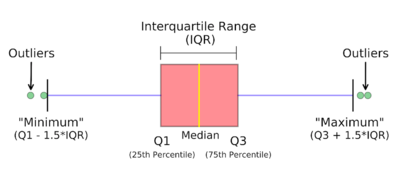

* Q1 = 1.Quartile 25%
* Q2 = 2.Quartile 50% (median)
* Q3 = 3.Quartile 75%
* IQR = Q3 - Q1
* Outlier data = (Q1 - 1.5 IQR ) U (Q3 + 1.5 IQR)



En este apartado se van a detectar los outlier. Para ello, primero se va a obtener información de las variables numéricas.

In [ ]:
train_data.describe()

Con el estudio de los estadísticos vemos que las variables `Age`, `SibSp`, `Parch` y `Fare` presentan outlier:
* Para `Age` vemos que la media de sus valores es 29, y el tercer cuartil es 38, sin embargo el máximo valor es 80. Por lo que hemos detectado que esta variable tiene al menos un outlier con valor 80.
* Para `SibSp`vemos la media con un valor de 0.52, el tercer cuartil con 1, y sin embargo el máximo valor es 8, por lo que hemos detectado un outlier.
* Para `Parch` vemos su madia de 0.38, su tercer cuartil vale 0, y el máximo vale 6.
* Para `Fare` su media vale 32 y su tercer cuartil 31, sin embargo tiene un valor máximo de 512. Este outlier es el más alejado de todos los que hemos detectado.

Ahora se define una función para eliminar estos outlier.

In [ ]:
def outlier_detect(feature, data):
    outlier_index = []

    for each in feature:
        Q1 = np.percentile(data[each], 25)
        Q3 = np.percentile(data[each], 75)
        IQR = Q3 - Q1
        min_quartile = Q1 - 1.5*IQR
        max_quartile = Q3 + 1.5*IQR
        outlier_list = data[(data[each] < min_quartile) | (data[each] > max_quartile)].index
        outlier_index.extend(outlier_list)
        
    outlier_index = Counter(outlier_index)
    #If there are three or more outlier data features we must delete them. (n)
    outlier_data = list(i for i, n in outlier_index.items() if n > 3)
    return outlier_data

Se van a eliminar los outlier de las variables que hemos detectado que tienen algún outlier, que eran: `Age`, `SibSp`, `Parch` y `Fare`. Se van a eliminar los outlier de las variables solo si hay más de tres outlier en esa variable.

Nosotros habríamos eliminado los outlier en el preprocesamiento después de haber terminado el análisis exploratorio, y lo habríamos incluido en el pipeline como hicimos en la práctica 1. Además, aquí se define una función para eliminar los outlier, y este es un trabajo innecesario, ya que `Scikit` tiene funciones implementadas que realizan esta función, y no sería necesario escribir nuestra propio función.

In [ ]:
outlier_data = outlier_detect(["Age","SibSp","Parch","Fare"], train_data)
train_data.loc[outlier_data]

Obtenemos que no se ha detectado ningún outlier porque hay menos de tres outlier en cada variable por lo que no merece la pena eliminar ninuna instancia.

In [ ]:
train_data = train_data.drop(outlier_data, axis=0).reset_index(drop=True)

### 1.2. Combina los datos

Ahora se van a combinar los datos de test y de entrenamiento para obtener todos los datos juntos. Esta variable no la usaremos para nada, ya que en la libreta ha utilizado todos los datos para hacer el análisis exploratorio, pero esto es incorrecto ya que no podemos utilizar la información de los datos de test en el análisis exploratorio.

In [ ]:
data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

## 2. Análisis de datos

En este apartado se va a realizar el análisis exploratorio. Cuando se realizo el `data_train.info()` obtuvimos el tipo de cada variable:

Variables tipo Object:
1. Name        : nombre de los pasajeros
1. Sex         : hombre y mujer (male and female)
1. Ticket      : número del ticket
1. Cabin       : categoría de la cabina
1. Embarked    : puerto (puede ser C, Q, S)

Variables tipo Int64
1. PassengerId : id único de los pasajeros
1. Survived    : 0 -> muerto ,1-> sobrevivió. Esta es la variable clase.
1. Pclasss     : Clase de ticket: 1, 2 y 3 
1. SibSp       : Cantidad de hermanos / esposo/a a bordo
1. Parch       : Cantidad de padres / hijos a bordo

Variables tipo Float64:
1. Age         : edad del pasajero
1. Fare        : precio del ticket

Primero se realiza un análisis univariado de la variable clase, que es la variable `Survived`, y es una variable categórica, que está formada por dos estados distintos, 0 y 1.

In [ ]:
sns.countplot('Survived',data=train_data)

Vemos que la muestra está desbalanceada, ya que hay casi el doble de casos en los que la variable clase vale 0, que los que vale 1. Por lo que tenemos más casos en los que no se sobrevivió, que los que si se sobrevivió.

Ahora vamos a ver la relación que tiene cada variable predictora con la variable clase de forma individual.
* Sex - Survived
* Pclass - Survived
* Embarked - Survived
* SibSp - Survived
* Parch - Survived
* Age - Survived
* Fare - Survived

#### Sex - Survived

Aquí se ha realizado una fuga de datos (aquí y en todo el análisis exploratorio), pues se ha realizado el análisis exploratorio con la variable `data`, que incluye a los datos de entrenamiento y a los de test. Se ha dejado comentada la línea de código original que utilizaba todos los datos para que se vea el error en este caso, pero nosotros vamos a utilizar solo los datos de entrenamiento, y para el resto de casos corregiremos esta línea.

In [ ]:
#data[["Sex", "Survived"]].groupby(["Sex"], as_index = False).mean()
train_data[["Sex", "Survived"]].groupby(["Sex"], as_index = False).mean()

In [ ]:
sns.factorplot(x="Sex", y ="Survived", data=train_data, kind="bar", size=3)
plt.show()

Vemos que un 74% de las mujeres sobreviven, mientras que de los hombres solo sobreviven un 18%. Por lo que las mujeres sobreviven más que los hombres.

### Pclass - Survived

In [ ]:
sns.factorplot(x="Pclass", y ="Survived", data=train_data, kind="bar", size=3)
plt.show()

Vemos que los pasajeros que tenían un ticket de 1 sobrevivieron más que los que tenían un ticket de 2, que a su vez, sobrevivieron más que los que tenían un ticket de 3.

### Embarked - Survived

In [ ]:
sns.factorplot(x="Embarked", y ="Survived", data=train_data, kind="bar", size=3)
plt.show()

Vemos que los que pertenecían al puerto de embarcación de C, sobrevivieron más que los del puerto S y Q. Mientras que la cantidad de pasajeros que sobrevivieron de los puertos S y Q es muy similar.

### SibSp - Survived

In [ ]:
sns.factorplot(x="SibSp", y ="Survived", data=train_data, kind="bar", size=3)
plt.show()

Vemos que los pasajeros con 1 `SibSp` tienen un mayor porcentaje de haber sobrevivido que el resto.

### Parch - Survived

In [ ]:
sns.factorplot(x="Parch", y ="Survived", data=train_data, kind="bar", size=3)
plt.show()

Aquí etá más repartido ya que los valores de 1, 2 y 3 para `Parch` tienen la misma frecuencia para la clase.

 ### Age - Survived

In [ ]:
g = sns.FacetGrid(train_data, row="Survived")
g.map(sns.distplot, "Age", bins=25)
plt.show()

Vemos que las dos gráficas siguen una distribución normal, por lo que no podemos intuir a priori si esta variable es inútil para la clasificación. Aunque si nos fijamos en las dos gráficas vemos que hay la misma cantidad de valores para los mismos datos, es decir, que independientemente de si `Survived `vale 1 o 0, los dos gráficos son muy similares, por lo que parece que esta variable no aporta mucha información.

 ### Fare - Survived

In [ ]:
g = sns.FacetGrid(train_data, row="Survived")
g.map(sns.distplot, "Fare", bins=25)
plt.show()

Vemos que las dos gráficas siguen una distrbucióna asimétrica positiva, por lo que al no seguir una distribución uniforme pueden aportar algo de información. Aunque si nos fijamos en que las dos gráficas son muy similares, concluimos que por si sola esta variable no aporta mucha información.

Veremos como se relaciona con el resto en el análisis multivariado, al igual que `Age`, que por si sola tampoco parece que aporte información.

<a id='7'></a><br>
### 2.2. Matriz de correlación

Para realizar un análisis multivariado, en el que vemos como se relacionan las variables, se va utilizar una matriz de correlación. Se ha vuelto a realizar una fuga de datos, ya que ha utilizado todos los datos para calcular la matriz de correlación. Nosotros lo corregiremos y utilizaremos solo los datos de entrenamiento.

In [ ]:
train_data['Sex'].replace(['male','female'],[0,1],inplace=True) # Se sustituyen las categoias de la variable por 0 y 1
train_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
# male: 0, famela: 1
sns.heatmap(train_data[["Age","Sex","SibSp","Parch","Pclass","Fare","Embarked", "Survived"]].corr(), annot = True)
plt.show()

Podemos ver que las variables `Sex`, `Pclass`, `Fare`y `Embarked` están relacionadas con la variable clase `Survived`.

Para saber si están relacionandas nos fijamos en que el valor que pueden tomar está en el intervalo [-1, +1]. Y sabemos que cuanto más cerca del 0 esté, significa que no hay relación entre las dos variables, mientras que cuanto más cerca esté del -1 o +1 significa que hay relación entre esas dos variables.
* Vemos que la relación entre `Sex` y `Survived` es de 0.54, que está más próximo de 1 que de 0.
* La vairable `Pclass` tiene una relación de -0.34 con `Survived`, que aunque esté más cerca del 0 que del -1, vemos que tiene algo de relación.
* Con `Fare` y `Embarked` pasa lo mismo, tienen una relación con `Survived`del 0.26 y 0.11, y aunque no haya tanta relacion como con `Sex`, si quetienen relación con la variable clase.
* Por el contrario las variables`Age`, `SibSp` y `Parch` no tienen casi relación con la variable clase pues su valor de la matriz de correlación es menor de 0.1.

## 3. Valores perdidos


Vimos al principio con el `data_train.info()` que había valores perdidos en los datos. En este apartado se van a buscar y a tratar estos valores. En la libreta original encuentra muchos más valores perdidos que nosotros ya que utiliza el dataset completo (train y test) para el análisis exploratorio. Nosotros corregiremos esto.

### 3.1. Encontrar valores perdidos

In [ ]:
train_data.columns[train_data.isnull().any()]

Vemos que las variables `Age`, `Cabin` y `Embarked` presentan algún valor perdido. Vamos a comprobar cuantos valores perdidos tienen cada variable.

Correlation Matrix
* Pclass is associated with Fare.
* Embarked is not associated with any feature.
* Pclass and SibSp are associated with Age.

In [ ]:
train_data.isnull().sum()

### 3.2. Rellenar los valores perdidos

* Age tiene 177 valores perdidos
* Cabin tiene 687 valores perdidos
* Embarked tiene 2 valores perdidos

#### Age

Como sabemos de la matriz de correlación `Age` tiene relación con las variables `Pclass`(0.37) y `SibSp` (0.31), por lo que para asignarle un valor a los casos perdidos de `Age`, se usará la información de la variable que más este relacionada con ella, que en este caso es `Pclass`.

Visualizamos las instancias en las que `Age` está a null.

In [ ]:
train_data[train_data["Age"].isnull()]

Se utilizará la mediana de los valores, que tengan el mismo valor en la variable `Pclass`. Es decir, para cada registro con `Age` on valor nulo, se escogerán todos los casos en los que la variable `Pclass` valga lo mismo que el de ese registro, y se calculará la mediana del valor de `Age` en todos esos casos y se le asignará ese valor al registro con `Age` nulo.

In [ ]:
data_age_nan_index = train_data[train_data["Age"].isnull()].index
for i in data_age_nan_index:
    mean_age = train_data["Age"][(train_data["Pclass"]==train_data.iloc[i]["Pclass"])].median()
    train_data["Age"].iloc[i] = mean_age

Comprobamos que en los datos de entrenamiento ya no hay instancias con `Age` a null.

In [ ]:
train_data[train_data["Age"].isnull()]

#### Cabin

La mayoría de los valores de esta variable son nulos, por lo que se eliminará esta variable por completo, en lugar de tratar sus valores.

#### Embarked

De la matriz de correlación anterior vemos que `Embarked` no está relacionado con ninguna variable (excepto la variable clase). Y también tiene un pocoo de relación con `Sex`, aunque tiene poca (0.12), y ya que solo hay dos valores perdidos, para rellenarlos se les asignará el valor mayoritario, que como en el gráfico del análisis univariado era 1 (C).

Visualizamos las instancias en las que `Embarked` está a null.

In [ ]:
train_data[train_data["Embarked"].isnull()]

Le asignamos un 1 a las instancias correspondientes.

In [ ]:
train_data["Embarked"] = train_data["Embarked"].fillna(1)

Comprobamos que en los datos de entrenamiento ya no hay instancias con `Embarked` a null.

In [ ]:
train_data[train_data["Embarked"].isnull()]

<a id='8'></a><br>
# 4. Ingeniería de datos.


En este apartado el autor realiza cambios en los datos del dataset, como la creación de nuevos atributos con la combinación de otros ya existentes para incrementar la información de clasificación. La eliminación de valores dentro de un atributo para generalizar. Y la eliminación de atributos que no aportan más información al clasificador (por ejemplo, `Cabin` que casi todos sus valores valen null).

<a id='12'></a><br>
## 4.1. Nuevos atributos.

Crearemos nuevas columnas para la base de datos con la informacion de otras. Aquí se ha realizado fuga de datos, nosotros en su lugar utilizaremos un pipeline.

Vamos a crear a su vez una dataframe por separado para hacer las mismas transformaciones fuera del pipeline, para ver las gráficas de como quedaria nuestra base de datos y al final sacar una matriz de correlaciones, para ver si se puede eliminar columnas que aportan la misma información que otras al haber creado nuevas columnas. Y así seguimos la misma estructura que la libreta original.

In [ ]:
train_clone = train_data.copy()

### Alone and Family 
* SibSp + Parch = family

A partir del número de hermanos y número de padres, se puede crear una variable del número de miembros de la familia. 

In [ ]:
train_data

Creamos una función que realizará esto para incorporarla en el pipeline.

In [ ]:
def suma_columnas(data, column1, column2, result):
    data[result] = data[column1] + data[column2]
    return data

También lo haremos sobre los datos copiados para seguir la estructura, aunque no lo haremos sobre los datos de test para no comenter la fuga de datos.

In [ ]:
train_clone["Family"] = train_clone["SibSp"] + train_clone["Parch"]
#test_data["Family"] = test_data["SibSp"] + test_data["Parch"]
sns.factorplot(x="Family", y ="Survived", data=train_clone, kind="bar", size=3)
plt.show()

También podemos crear una variable de si esa persona viajaba sola. Si el valor de familia es 0 viajaba solo y se le pondrá un valor de 1. Si estaba acompañado un valor de 0.

In [ ]:
def alone_column(data, nombre, family):
    data[nombre] = [1 if i == 0 else 0 for i in data[family]]
    return data

In [ ]:
train_clone["Alone"] = [1 if i == 0 else 0 for i in train_clone["Family"]]
#test_data["Alone"] = [1 if i == 0 else 0 for i in test_data["Family"]]
#train_data["Family"].replace([0,1,2,3,4,5,6,7,10], [0,1,1,1,0,2,0,2,2], inplace=True)
train_clone.head()

### Name - Title

Hay diferentes categorías de los titulos con los que se llama a una persona. Podemos reducir los titulos que tenga menos instancias en la base de datos los podemos denominar como "Other".

In [ ]:
def name_title(data, nombre):
    data[nombre] = data.Name.str.extract('([A-Za-z]+)\.')
    data[nombre].replace(['Mme','Ms','Mlle','Lady','Countess','Dona','Dr','Major','Sir','Capt','Don','Rev','Col', 'Jonkheer'],['Miss','Miss','Miss','Mrs','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Other','Other','Other'], inplace=True)
    # Se convierten los titulos en identificadores numericos
    data[nombre].replace(["Mr","Mrs","Miss","Master","Other"], [1,2,2,3,1], inplace=True)
    return data

In [ ]:
train_clone['Title']=train_clone.Name.str.extract('([A-Za-z]+)\.')
#test_data['Title']=test_data.Name.str.extract('([A-Za-z]+)\.')

In [ ]:
#sns.countplot(train_data["Title"])
#plt.xticks(rotation = 90)
#plt.show()

In [ ]:
train_clone['Title'].replace(['Mme','Ms','Mlle','Lady','Countess','Dona','Dr','Major','Sir','Capt','Don','Rev','Col', 'Jonkheer'],['Miss','Miss','Miss','Mrs','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Other','Other','Other'], inplace=True)
#test_data['Title'].replace(['Mme','Ms','Mlle','Lady','Countess','Dona','Dr','Major','Sir','Capt','Don','Rev','Col', 'Jonkheer'],['Miss','Miss','Miss','Mrs','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Other','Other','Other'], inplace=True)

In [ ]:
sns.countplot(train_clone["Title"])
plt.show()

In [ ]:
sns.factorplot(x="Title", y ="Survived", data=train_clone, kind="bar", size=3)
plt.show()

Convertimos los titulos en identificadores numéricos.

In [ ]:
train_clone["Title"].replace(["Mr","Mrs","Miss","Master","Other"], [1,2,2,3,1], inplace=True)
#test_data["Title"].replace(["Mr","Mrs","Miss","Master","Other"], [1,2,2,3,1], inplace=True)

### Age Limit

Para estos dos nuevos atributos se utiliza la variable clase para agrupar los de un mismo rango de edad. Como la variable clase no la obtenemos en el dataset del test, todos los pasos siguientes se comentarán. Esta variable además es redundante con el atributo edad. Así que no lo pasaremos al pipeline.

In [ ]:
"""
def age_limit(data):
    data['Age_Limit'] = pd.cut(data['Age'], 5)
    data.groupby(['Age_Limit'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')
    return data
"""

In [ ]:
#train_data['Age_Limit']=pd.cut(train_data['Age'], 5)
#test_data['Age_Limit']=pd.cut(test_data['Age'], 5)

#train_data.groupby(['Age_Limit'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')
#test_data.groupby(['Age_Limit'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

In [ ]:
#train_data['Age_Limit'] = LabelEncoder().fit_transform(train_data['Age_Limit'])
#test_data['Age_Limit'] = LabelEncoder().fit_transform(test_data['Age_Limit'])

### Fare Limit

Al igual que on `Age limit` para generar esta variable utiliza los datos de test así que comentaremos estos pasos.

In [ ]:
#train_clone['Fare_Limit']=pd.qcut(train_clone['Fare'],4)
#train_clone.groupby(['Fare_Limit'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

In [ ]:
#train_clone['Fare_Limit'] = LabelEncoder().fit_transform(train_clone['Fare_Limit'])
#test_data['Age_Limit'] = LabelEncoder().fit_transform(test_data['Age_Limit'])

In [ ]:
#sns.factorplot(x="Fare_Limit", y ="Survived", data=train_clone, kind="bar", size=3)
#plt.show()

### Correlation Matrix

Con las nuevas variables, la matriz de correlaciones quedan de esta manera:

In [ ]:
sns.heatmap(train_clone[["Ticket","Cabin","Pclass","Embarked","Sex","Age", "Title","Family", "Survived"]].corr(), annot = True)
plt.show()

<a id='13'></a><br>
## 4.2. Eliminación de variables
* Ticket, Cabin, Name y PassengerId son eliminadas por la poca correlación que hemos visto con otras variables.
* Además eliminaremos Cabin porque casi todos sus valores son desconocidos (valen null).
* El resto de variables que hemos utilizado para crear nuevas variables tambien las eliminaremos.

Las eliminaremos en el pipeline.

In [ ]:
train_data['Age']=train_data['Age'].astype(int)

columns_drop = ["SibSp","Parch","Cabin","Fare", "Ticket", "Name", "PassengerId"]

#train_data.drop(labels=columns_drop, axis=1, inplace = True)
#test_data.drop(labels=columns_drop, axis=1, inplace = True)

#train_data.head()

Nuestra base de datos por tanto queda muy reducida y con gran valor informativo para la clasificación.

<a id='14'></a><br>
## 4.3. One Hot Encoding

In [ ]:
#train_data = pd.get_dummies(data,columns=["Pclass"])
#train_data = pd.get_dummies(data,columns=["Embarked"])
#train_data = pd.get_dummies(data,columns=["Family"])
#train_data = pd.get_dummies(data,columns=["Title"])

#train_data.head()

<a id='16'></a><br>
# 5. Modelos

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

<a id='17'></a><br>
## 5.1 Train Test Split

Esta parte la vamos a comentar entera. Como el test y el train están en diferentes dataset cada uno cargados en una odentificador independiente no es necesario realizar un *houldout*. Al estar a divididos no tiene sentido unirlos y luego separarlos.

In [ ]:
#if len(data) == (len(train_data) + len(test_data)):
#    print("success")

In [ ]:
#test = data[len(train_data):]
#test.drop(labels="Survived", axis=1, inplace=True)

In [ ]:
#train = data[:len(train_data)]
#X_train = train.drop(labels = "Survived", axis=1)
#y_train = train["Survived"]
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


<a id='18'></a><br>
## 5.2. Metodos de clasificación.


* Logistic Regression
* Random Forest Regression
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

Estos serán los modelos que se estudian en el notebook original. Primero dividimos los datos test y train en sus diferentes variables. Para tener la variable clase dividida del resto. 

In [ ]:
target = "Survived"
(X_train,y_train) = (train_data.drop(target, axis=1), train_data[target])

#(X_test,y_test) = (test_data.drop(target, axis=1), test_data[target])
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline

sum_col = FunctionTransformer(suma_columnas, kw_args={'column1':"SibSp", 'column2':'Parch', 'result':'Family'})
alone_col = FunctionTransformer(alone_column, kw_args={'nombre':"Alone", 'family':'Family'})
name = FunctionTransformer(name_title, kw_args={'nombre':"Title"})
drop_col = make_column_transformer(("drop", columns_drop), remainder="passthrough")

### 5.2.1. Regresión logística

In [ ]:
log_reg = LogisticRegression(random_state=42)

p = make_pipeline(sum_col, alone_col, name, drop_col, log_reg)
p.fit(X_train, y_train)
print("Accuracy: ", p.score(X_test,y_test))

Para regresión logística obtenemos la mayor tasa de acierto, al ser un modelo simple lo consideraremos por encima del resto.

### 5.2.2. Random Forest

In [ ]:
rf_reg = RandomForestClassifier(random_state=42)
#rf_reg.fit(X_train, y_train)
#print("Accuracy: ", rf_reg.score(X_test,y_test))

p = make_pipeline(sum_col, alone_col, name, drop_col, rf_reg)
p.fit(X_train, y_train)
print("Accuracy: ", p.score(X_test,y_test))

Random forest, consigue menor *score* que el anterior aún siendo un modelo más complejo. Por tanto, lo descartaremos por modelos simples.

### 5.2.3. Support Vector Machine (SVM)

In [ ]:
svm_clsf = SVC()
#svm_clsf.fit(X_train, y_train)
#print("Accuracy: ", svm_clsf.score(X_test,y_test))

p = make_pipeline(sum_col, alone_col, name, drop_col, svm_clsf)
p.fit(X_train, y_train)
print("Accuracy: ", p.score(X_test,y_test))

La tasa de acierto en este caso es muy baja, respecto a los anteriores. Este modelo no servirá.

### 5.2.4. KNN


Para knn comprobamos del 1 al 12 en número de vecinos.

In [ ]:
best_knn = []
for n in range(1,12):
    knn = KNeighborsClassifier(n_neighbors=n)
    #knn.fit(X_train, y_train)
    #best_knn.insert(n, knn.score(X_test,y_test))
    p = make_pipeline(sum_col, alone_col, name, drop_col, knn)
    p.fit(X_train, y_train)
    best_knn.insert(n, p.score(X_test,y_test))
best_knn


In [ ]:
knn_clsf = KNeighborsClassifier(n_neighbors=5)
p = make_pipeline(sum_col, alone_col, name, drop_col, knn_clsf)
p.fit(X_train, y_train)
print("Accuracy: ", p.score(X_test,y_test))

Con el número de vecinos de 5 obtenemos la mayor tasa de acierto. Esta no es nada despreciable y queda muy cerca de regresión logística.

<a id='19'></a><br>
## 5.3. Modelos "Ensemble"

In [ ]:
voting_classfication = VotingClassifier(estimators = [('knn', knn_clsf),('lg', log_reg), ('rfg', rf_reg), ('svc', svm_clsf)], voting="hard", n_jobs=-1)
p = make_pipeline(sum_col, alone_col, name, drop_col, voting_classfication)
p.fit(X_train, y_train)
print("Accuracy: ", p.score(X_test,y_test))

El ensemble de los modelos anteriores por un metodo de voto da peores resultados qque un modelo más simple. Por tanto, para evaluar el modelo vamos a utilizar modelos simples.

<a id='20'></a><br>
## 5.4. Resultados


In [ ]:
#test_result = pd.Series(voting_classfication.predict(test_data), name = "Survived").astype(int)
#results = pd.concat([test_data["PassengerId"], test_result],axis = 1)
#results.to_csv("titanic_submission.csv", index = False)

Viendo los resultados que nos ofrecen los modelos al entrenarlo, no necesitamos más código. Ya hemos visto que el mejor es regresión logística y por debajo queda KNN que también nos aporta buenos resultados.

Además destacar que regresión logística ha obtenido muy buenos resultados para ser un modelo tan simple.